<a href="https://colab.research.google.com/github/NattLuangsirapornchai/Quantum-project/blob/main/qnn_withBackPropV1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit==0.12.0

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 21.6MB 1.4MB/s 
     |████████████████████████████████| 92kB 10.3MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 983kB 47.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 5.8MB 47.0MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 26.0MB 66.8MB/s 
     |████████████████████████████████| 573kB 43.3MB/s 
     |████████████████████████████████| 2.7MB 41.0MB/s 
  Created wheel for qiskit: filename=qiskit-0.12.0-cp36-none-any.whl size=1397 sha256=b0e62cbdf1ce1d1f61d4d00615ea596f00ecd5c8e6ceb8375a2f82934710b0de
  Stored in directory: /root/.cache/pip/wheels/de/fc/68/2318ad43f26583ec1ac8e30bedd43e71211c9256429b7f829c
  Created wheel for dlx: filename=dlx-1.0.4-cp36-none-any.whl size=5712 sha25

In [ ]:
# initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sympy as sp
from sympy.physics.quantum import TensorProduct
from sympy.core.numbers import I

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [ ]:
def preparation(circuit, n, idx) :
    for i in range(n) :
        circuit.ry(trans1_y[idx],i)
        circuit.rz(trans1_z[idx],i)
    circuit.barrier()
    
def entangling_gate(circuit, n) : #u_ent
    for i in range(n-1) :
        circuit.cz(i,i+1)
    circuit.cz(n-1,0)

def local_unitary(circuit, n, col) : #u_loc
    for i in range(n) :
        circuit.ry(weight[col],i)
        circuit.rz(weight[col],i)

def variational_circuit(circuit,n,l) :
    local_unitary(circuit,n, 0)
    circuit.barrier()
    for loc in range (l) :
        entangling_gate(circuit,n)
        local_unitary(circuit,n,loc+1)
        circuit.barrier()

def forcasting(prob,n) :
    forcastlist = []
    result = list(prob.keys())
    for qubit in range(n) :
        prob_0 = 0 ; prob_1 = 0
        for bnr in result :
            if bnr[n-1-qubit] == '0' :
                prob_0 += prob[bnr]/2048
            else :
                prob_1 += prob[bnr]/2048
        forcast = 2*(prob_0 + (-1)*prob_1) #inside is expected value
        forcastlist.append(forcast)
    return forcastlist

def distributed_error(error,n) :
    dzdp = []
    for state in range(2**n) :
        row = []
        for qb in range(n) :
            if state//(2**qb)%2 == 0 : row.append(1)
            else : row.append(-1)
        dzdp.append(row)
    dL_dp = np.array(dzdp).dot(np.transpose(error))/n
    return dL_dp

def forcasting0(prob,n) :
    prob_0 = 0 ; prob_1 = 0
    result = list(prob.keys())
    for bnr in result :
        if bnr[n-1] == '0' :
            prob_0 += prob[bnr]/2048
        else :
            prob_1 += prob[bnr]/2048
    forcast = 2*(prob_0 + (-1)*prob_1) #inside is expected value
    return forcast

## Regression Circuit

In [ ]:
def condition(turn) :
  return turn%10==0

##### Input
#case: n=3, l=3
N = 3
L = 3
#mode = 'y' # y or z
no_training = 121

##### Training Data
#f(x) = x
domain = np.linspace(-1,1,10)
preimage = domain*1
trans1_z = np.arccos(domain**2)
trans1_y = np.arcsin(domain)

##### Matrix Collection
x = sp.Symbol("x", real=True) 
ry_gate = sp.Matrix([[sp.cos(x/2) , -sp.sin(x/2)],
                                  [sp.sin(x/2) , sp.cos(x/2)]])
rz_gate = sp.Matrix([[     1,     0],
                                  [     0,     sp.exp(I*x)]])
rzy_gate = rz_gate * ry_gate
prepared_y =  sp.Matrix([[1]])
prepared_z = sp.Matrix([[1]])
uloc = sp.Matrix([[1]])
for i in range(N) : 
    prepared_y = TensorProduct(prepared_y,ry_gate)
    prepared_z = TensorProduct(prepared_z,rz_gate)
    uloc = TensorProduct(uloc,rzy_gate)
uloc_diff = uloc.diff(x)

uc = QuantumCircuit(N,N)
for i in range(N-1) :
    uc.cz(i,i+1)
uc.cz(N-1,0)
from qiskit.quantum_info import Operator
uent = np.array(Operator(uc).data)

##### Weight 
# np.random.seed(0)
weight = 2*np.pi*np.random.random(L+1)  # uloc_theta: dim = 1x(L+1)
print(weight)

##### Result of Prediction
last_result = []

##### Noise Model
error_meas = pauli_error([('Y',0.018), ('Z', 0.018), ('I', 1-0.036)])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_meas, "measure")

[6.0548717  2.40923412 4.97455513 3.32314479]


In [ ]:
from qiskit.providers.aer import noise
for turn in range(no_training) :
    temp = []
    for idx in range(len(domain)) :
        ###Preparing Matrix
        begin = np.zeros((2**N,1)) ; begin[0] = 1
        prepared = prepared_z.subs(x,trans1_z[idx]) * prepared_y.subs(x,trans1_y[idx])
        wf_in = np.array(prepared, dtype=np.complex).dot(begin)
        statelist = [] ; statelist.append(wf_in)
        for i in range(L) :
            wf_in = np.array(uloc.subs(x,weight[i]), dtype=np.complex).dot(wf_in)
            wf_in = uent.dot(wf_in)
            statelist.append(wf_in)
        wf_out = np.array(uloc.subs(x,weight[L]), dtype=np.complex).dot(wf_in)
        #print("Preparing Finished")
        ###Quantum Circuit
        qc = QuantumCircuit(N,N)
        preparation(qc,N,idx)
        variational_circuit(qc,N,L)
        for i in range(N) :
            qc.measure(i,i)
        ###Simulation&Find error
        prob = execute(qc,Aer.get_backend('qasm_simulator'),shots=2048
             #,noise_model=noise_model, 
             ).result().get_counts()    #Qasm cannot count and get statevector in the same time 
        ###
        # forcasted = np.array(forcasting(prob,N))
        # error = forcasted - np.full((1,N), preimage[idx])
        # dL_dp = distributed_error(error,N)
        ###
        forcasted = forcasting0(prob,N)
        error = forcasted - preimage[idx]
        dL_dp = np.full((2**N,1), error) * np.kron( np.full((2**N//2,1),1), np.array([[1],[-1]]))
        ###
        if condition(turn) :
            # temp.append(forcasted[0])
            temp.append(forcasted)
        ###Backpropagation
        dL_dy = np.real(dL_dp * np.conjugate(wf_out)) #multiply mapping
        all_one = np.ones((1,2**N)) 
        uent_t = np.array(uent.T)
        for i in range(L,-1,-1) :
            #Find Input Error
            dL_dx = (np.array(uloc.subs(x,weight[i]).T, dtype=np.complex).dot(dL_dy)).real
            #Find Weight Error
            dL_dw = dL_dy.dot(np.transpose(statelist[i].real))
            dL_dw = np.multiply(dL_dw, np.real(np.array(uloc_diff.subs(x,weight[i]), dtype=np.complex))) 
            dL_dtheta = all_one.dot(dL_dw.dot(np.transpose(all_one)))
            weight[i] += float(dL_dtheta[0][0])
            #####
            dL_dy = dL_dx
            # if i > 0 :
            #     dL_dy = uent_t.dot(dL_dy)
            #print(dL_dy)
    if condition(turn) :
        last_result.append(temp)

print("Training is finished")

Training is finished


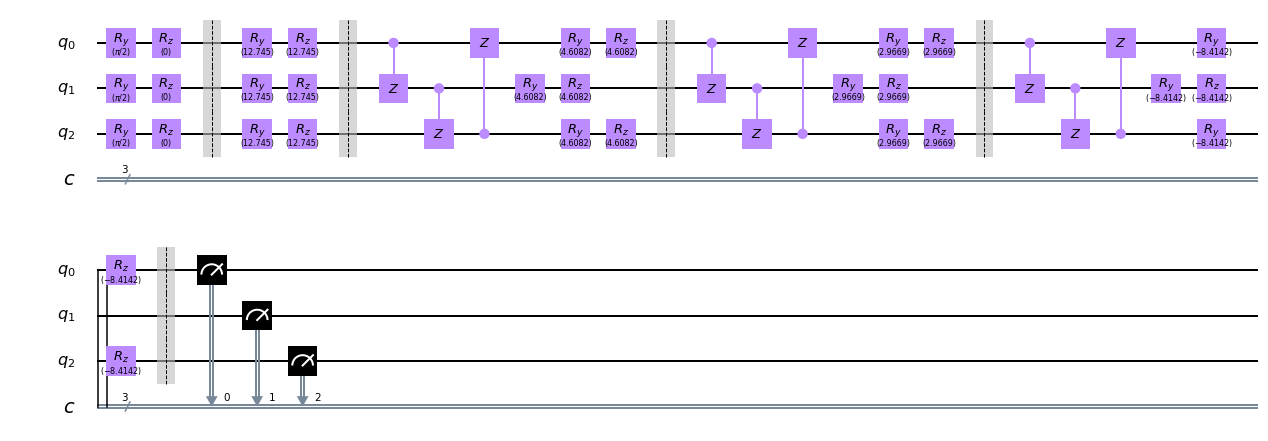

In [ ]:
qc.draw(output='mpl')

In [ ]:
print(last_result)

[[-0.162109375, 0.09765625, 0.025390625, 0.34765625, 0.640625, 0.685546875, 1.203125, 1.244140625, 0.7890625, -0.5078125], [-1.044921875, -0.76953125, -0.439453125, -0.302734375, -0.16796875, 0.017578125, 0.107421875, 0.185546875, -0.09765625, 1.05078125], [-0.5703125, 0.287109375, 0.30859375, 0.2265625, 0.087890625, 0.236328125, 0.14453125, 0.26171875, 0.296875, 1.443359375], [-0.775390625, -1.01953125, -0.83203125, -0.603515625, -0.388671875, -0.11328125, 0.03125, -0.14453125, -0.359375, 0.59375], [-0.361328125, -0.98046875, -0.712890625, -0.330078125, -0.177734375, -0.015625, 0.14453125, 0.138671875, -0.091796875, 1.02734375], [-0.951171875, -0.30859375, -0.0078125, -0.318359375, -0.255859375, -0.2265625, -0.083984375, 0.390625, 0.533203125, 0.154296875], [-1.02734375, -0.650390625, -0.30078125, -0.2109375, -0.177734375, 0.001953125, 0.048828125, 0.1796875, 0.0390625, 1.021484375], [-0.857421875, -0.890625, -0.681640625, -0.466796875, -0.080078125, 0.22265625, 0.4921875, 0.791015625

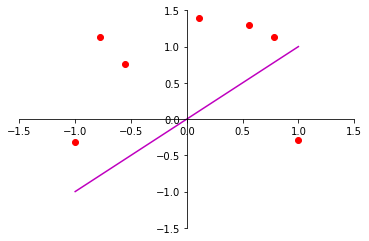

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.axis([-1.5,1.5,-1.5,1.5])

plt.plot(domain,last_result[10],'ro')
plt.plot(domain, preimage, 'm')
#plt.plot(ans)

In [ ]:
mean_square_error = []
for idx in range(0,len(last_result)) :
  all_error = 0
  for j in range(len(last_result[idx])) :
    all_error += (last_result[idx][j] - preimage[j])**2
  all_error /= len(preimage)
  mean_square_error.append('%.4f'%(all_error))

import plotly.graph_objects as go
each_training = np.arange(0,no_training,10)
fig = go.Figure(data=[go.Table(
    header=dict(values=['No. of Training', 'Mean Square Error'], line_color='darkslategray',
                fill_color='lightskyblue', align='left'),
    cells=dict(values=[each_training, mean_square_error], line_color='darkslategray',
               fill_color='lightyellow', align='left'))
])
fig.update_layout(width=500, height=500)
fig.show()